In [199]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [200]:
#path = '../dataset/gemini_BTCUSD_2019_1min.csv'
path = '../../dataset/gemini_BTCUSD_2019_1min.csv'
# Skipping the first line of the csv-file
with open(path, 'r') as f:
    next(f)
    df = pd.read_csv(f, parse_dates = ['Date'])#, index_col = 'Date')

print(df.head())

   Unix Timestamp                Date  Symbol     Open     High      Low  \
0   1592352000000 2020-06-17 00:00:00  BTCUSD  9526.40  9539.67  9526.40   
1   1592351940000 2020-06-16 23:59:00  BTCUSD  9525.68  9532.30  9525.68   
2   1592351880000 2020-06-16 23:58:00  BTCUSD  9521.38  9531.92  9521.38   
3   1592351820000 2020-06-16 23:57:00  BTCUSD  9525.20  9526.45  9521.27   
4   1592351760000 2020-06-16 23:56:00  BTCUSD  9522.95  9525.20  9518.31   

     Close    Volume  
0  9533.36  0.020150  
1  9526.40  0.006691  
2  9525.68  0.049345  
3  9521.38  0.292681  
4  9525.20  3.621439  


In [201]:
df = df[['Date', 'Open', 'Volume']]
print(df.dtypes)

Date      datetime64[ns]
Open             float64
Volume           float64
dtype: object


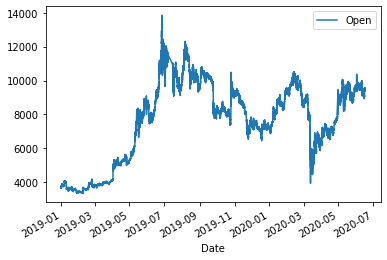

In [202]:
df.plot(x = 'Date', y = 'Open')

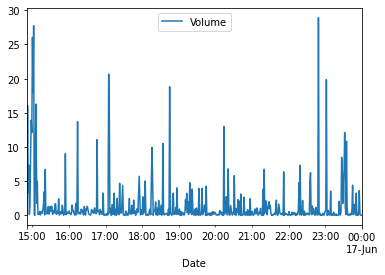

In [203]:
df.iloc[:550].plot(x = 'Date', y = 'Volume')

In [204]:
# Converting to percentage change between the current and prior element
print(df.head())
#df[['Open', 'Volume']] = df[['Open', 'Volume']].pct_change()
df['Open'] = df['Open'].pct_change()
df = df.drop(index = 0) # Drop the first row since it is NaN due to pct_change()
print(df.head())

                 Date     Open    Volume
0 2020-06-17 00:00:00  9526.40  0.020150
1 2020-06-16 23:59:00  9525.68  0.006691
2 2020-06-16 23:58:00  9521.38  0.049345
3 2020-06-16 23:57:00  9525.20  0.292681
4 2020-06-16 23:56:00  9522.95  3.621439
                 Date      Open    Volume
1 2020-06-16 23:59:00 -0.000076  0.006691
2 2020-06-16 23:58:00 -0.000451  0.049345
3 2020-06-16 23:57:00  0.000401  0.292681
4 2020-06-16 23:56:00 -0.000236  3.621439
5 2020-06-16 23:55:00 -0.000003  0.064634


In [205]:
# Converting to a numpy-array, dropping the 'Date'-column and standardizing
df = df[['Open', 'Volume']].to_numpy()
df = (df-df.mean(axis=0))/df.std(axis=0)
print(type(df), df.shape, df[0])

<class 'numpy.ndarray'> (712795, 2) [-0.06260313 -0.18780868]


In [206]:
df = df[:10]
print(df.shape)
print(df[:10])

(10, 2)
[[-6.26031314e-02 -1.87808680e-01]
 [-3.76452890e-01 -1.82530662e-01]
 [ 3.35547875e-01 -1.52420119e-01]
 [-1.96747124e-01  2.59481754e-01]
 [-2.11897951e-03 -1.80638800e-01]
 [-2.75495535e-02 -1.82957596e-01]
 [-3.15188629e-01 -1.52351447e-01]
 [ 5.11760372e-04 -1.88636620e-01]
 [ 1.19360872e+00  2.13378392e-01]
 [ 5.11760372e-04 -1.81664702e-01]]


In [207]:
# Converting the dataset (numpy-array) to a numpy-array which fits the model
# The first dimension represents the number of examples
# The second dimension represents the length of the time series used to make a prediction
# The third dimension represents the number of features used (e.g. 'Open', 'Volume' etc)

# future_pred = 0 means that we are predicting only one time step in the future
# seq_len represents the length of the time series used to make a prediction
def to_sequences(dataset, seq_len, future_pred):
    
    features = []
    labels = []
    
    i = 0
    #label = dataset[seq_len+future_pred, :]

    while i+seq_len+future_pred < len(dataset):
        feature = dataset[i:i+seq_len, :]
        features.append(feature)
        
        label = dataset[i+seq_len+future_pred, :]
        labels.append(label)
        
        i += 1
        
    return np.array(features), np.array(labels)
    

In [208]:
features, labels = to_sequences(dataset = df, seq_len = 3, future_pred = 0)
print(features.shape, '\n', features)
print(labels.shape, '\n', labels)

(7, 3, 2) 
 [[[-6.26031314e-02 -1.87808680e-01]
  [-3.76452890e-01 -1.82530662e-01]
  [ 3.35547875e-01 -1.52420119e-01]]

 [[-3.76452890e-01 -1.82530662e-01]
  [ 3.35547875e-01 -1.52420119e-01]
  [-1.96747124e-01  2.59481754e-01]]

 [[ 3.35547875e-01 -1.52420119e-01]
  [-1.96747124e-01  2.59481754e-01]
  [-2.11897951e-03 -1.80638800e-01]]

 [[-1.96747124e-01  2.59481754e-01]
  [-2.11897951e-03 -1.80638800e-01]
  [-2.75495535e-02 -1.82957596e-01]]

 [[-2.11897951e-03 -1.80638800e-01]
  [-2.75495535e-02 -1.82957596e-01]
  [-3.15188629e-01 -1.52351447e-01]]

 [[-2.75495535e-02 -1.82957596e-01]
  [-3.15188629e-01 -1.52351447e-01]
  [ 5.11760372e-04 -1.88636620e-01]]

 [[-3.15188629e-01 -1.52351447e-01]
  [ 5.11760372e-04 -1.88636620e-01]
  [ 1.19360872e+00  2.13378392e-01]]]
(7, 2) 
 [[-1.96747124e-01  2.59481754e-01]
 [-2.11897951e-03 -1.80638800e-01]
 [-2.75495535e-02 -1.82957596e-01]
 [-3.15188629e-01 -1.52351447e-01]
 [ 5.11760372e-04 -1.88636620e-01]
 [ 1.19360872e+00  2.13378392e-01]